**Noms:** <br>Marilyn CHAHINE<br>Marina SANGINETO

# XAI - TME 6 - La librairie Captum

In [214]:
# captum imports
import numpy as np
import torch
from captum.attr import IntegratedGradients
from captum.attr import LayerConductance
from captum.attr import NeuronConductance

# other imports
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import stats
import pandas as pd
import sklearn
from sklearn import svm
from collections.abc import Sequence
from numpy.typing import NDArray
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons, load_breast_cancer, load_wine
from sklearn.ensemble import RandomForestClassifier
import torch.nn as nn
from lime import lime_tabular
from lime.lime_tabular import LimeTabularExplainer
import shap

# Generating Explanations for Half-Moon Data using Integrated Gradients

In [215]:
X, y = sklearn.datasets.make_moons(n_samples=1000, shuffle=True, noise=None, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [216]:
torch.manual_seed(42)

class MoonsNNModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(2, 12)
        self.sigmoid1 = nn.Sigmoid()
        self.linear2 = nn.Linear(12, 8)
        self.sigmoid2 = nn.Sigmoid()
        self.linear3 = nn.Linear(8, 2)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        lin1_out = self.linear1(x)
        sigmoid_out1 = self.sigmoid1(lin1_out)
        sigmoid_out2 = self.sigmoid2(self.linear2(sigmoid_out1))
        return self.softmax(self.linear3(sigmoid_out2))

net = MoonsNNModel()

criterion = nn.CrossEntropyLoss()
num_epochs = 200

optimizer = torch.optim.Adam(net.parameters(), lr=0.1)
input_tensor = torch.from_numpy(X_train).type(torch.FloatTensor)
label_tensor = torch.from_numpy(y_train)
for epoch in range(num_epochs):    
    output = net(input_tensor)
    loss = criterion(output, label_tensor)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if epoch % 20 == 0:
        print ('Epoch {}/{} => Loss: {:.2f}'.format(epoch+1, num_epochs, loss.item()))

torch.save(net.state_dict(), 'models/moons_model.pt')

Epoch 1/200 => Loss: 0.69
Epoch 21/200 => Loss: 0.42
Epoch 41/200 => Loss: 0.42
Epoch 61/200 => Loss: 0.42
Epoch 81/200 => Loss: 0.42
Epoch 101/200 => Loss: 0.42
Epoch 121/200 => Loss: 0.42
Epoch 141/200 => Loss: 0.41
Epoch 161/200 => Loss: 0.35
Epoch 181/200 => Loss: 0.31


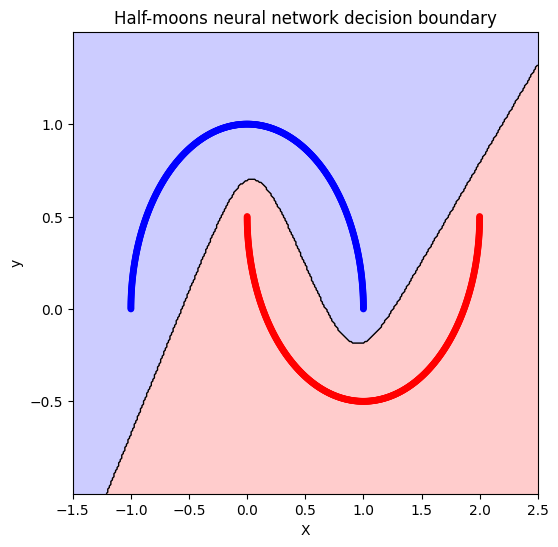

In [217]:
def plot_decision_boundary(model, X, y, title):
    xx, yy = np.meshgrid(np.linspace(X[:,0].min()-0.5, X[:,0].max()+0.5, 300),
                         np.linspace(X[:,1].min()-0.5, X[:,1].max()+0.5, 300))
    grid = np.vstack([xx.ravel(), yy.ravel()]).T
    model.eval()
    with torch.no_grad():
        out = model(torch.tensor(grid, dtype=torch.float32)).numpy()
        preds = out.argmax(axis=1)
    Z = preds.reshape(xx.shape)
    plt.figure(figsize=(6,6))
    plt.contourf(xx, yy, Z, levels=[-0.5,0.5,1.5], alpha=0.2, colors=['blue','red'])
    plt.contour(xx, yy, Z, levels=[0.5], linewidths=1, colors='k')
    plt.scatter(X[:,0], X[:,1], c=y, cmap='bwr', s=15)
    plt.title(title)
    plt.xlabel('X')
    plt.ylabel('y')
    plt.show()

plot_decision_boundary(net, X, y, title='Half-moons neural network decision boundary')

In [218]:
test_input_tensor = torch.from_numpy(X_test).type(torch.FloatTensor)
out_probs = net(test_input_tensor).detach().numpy()
out_classes = np.argmax(out_probs, axis=1)
print("Test Accuracy:", sum(out_classes == y_test) / len(y_test))

Test Accuracy: 1.0


In [219]:
np.random.seed(42)
points_to_explain = X_test[np.random.choice(X_test.shape[0], 5, replace=False), :]
print(points_to_explain)

[[ 1.66944246 -0.24286391]
 [-0.80827624  0.58880346]
 [ 1.96845778  0.25082231]
 [ 0.20298819 -0.10396372]
 [ 0.5604681   0.82817601]]


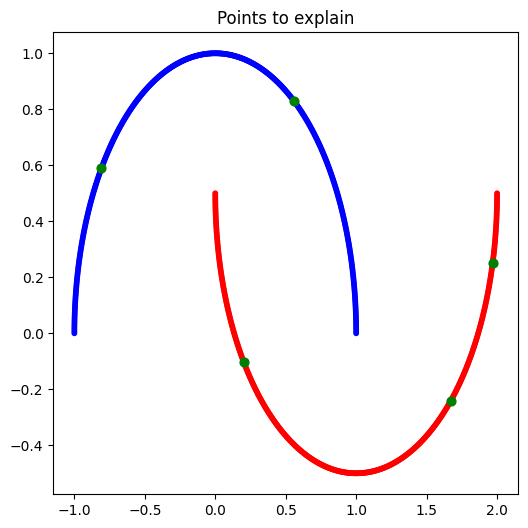

In [220]:
plt.figure(figsize=(6,6))
plt.scatter(X[:,0], X[:,1], c=y, cmap='bwr', s=10)
plt.scatter(points_to_explain[:,0], points_to_explain[:,1], c='green', s=40, marker='o')
plt.title('Points to explain')
plt.show()

In [221]:
def explain_ig(model, ig, inputs, target=1, baseline=None):
    model.eval()
    
    if baseline is None:
        baseline = torch.zeros_like(inputs)
    else:
        baseline = torch.tensor(baseline, dtype=torch.float32)
        
    attributions, delta = ig.attribute(inputs, baselines=baseline, target=target, return_convergence_delta=True)
    
    return attributions.detach().numpy(), delta.detach().numpy()

In [222]:
points_to_explain_t = torch.from_numpy(points_to_explain)
points_to_explain_t = points_to_explain_t.float()
points_to_explain_t.requires_grad_()

tensor([[ 1.6694, -0.2429],
        [-0.8083,  0.5888],
        [ 1.9685,  0.2508],
        [ 0.2030, -0.1040],
        [ 0.5605,  0.8282]], requires_grad=True)

In [223]:
ig = IntegratedGradients(net)
attr, delta = explain_ig(net, ig, points_to_explain_t, target=1, baseline=None)

In [224]:
for p in points_to_explain_t:
    p = p.reshape(1,-1)
    preds = net(torch.tensor(p, dtype=torch.float32)).detach().numpy()
    pred_class = preds.argmax()
    attr, delta = explain_ig(net, ig, p, target=int(pred_class), baseline=np.zeros_like(p.detach().numpy()))
    print('Point: ', p.detach().numpy().round(2)) 
    print('Pred_class: ', pred_class)
    print('Attribution: ', attr)
    print('Delta: ', delta, "\n")

Point:  [[ 1.67 -0.24]]
Pred_class:  1
Attribution:  [[-0.3934689   0.39302573]]
Delta:  [-0.00043756] 

Point:  [[-0.81  0.59]]
Pred_class:  0
Attribution:  [[0.6712314  0.32873064]]
Delta:  [1.1920929e-07] 

Point:  [[1.97 0.25]]
Pred_class:  1
Attribution:  [[ 0.24250554 -0.22430752]]
Delta:  [0.01835781] 

Point:  [[ 0.2 -0.1]]
Pred_class:  1
Attribution:  [[8.7318549e-06 4.7655562e-06]]
Delta:  [-9.244832e-08] 

Point:  [[0.56 0.83]]
Pred_class:  0
Attribution:  [[0.46249658 0.5377884 ]]
Delta:  [0.00030094] 



/tmp/ipykernel_465/1906824561.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  preds = net(torch.tensor(p, dtype=torch.float32)).detach().numpy()


/tmp/ipykernel_465/3204626006.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target=int(net(torch.tensor(p.reshape(1,-1),dtype=torch.float32)).argmax()))
/tmp/ipykernel_465/3204626006.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target=int(net(torch.tensor(p.reshape(1,-1),dtype=torch.float32)).argmax()))
/tmp/ipykernel_465/3204626006.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target=int(net(torch.tensor(p.reshape(1,-1),dtype=torch.float32)).argmax()))
/tmp/ipykernel_465/3204626006.py:5: UserWarning: To copy construct 

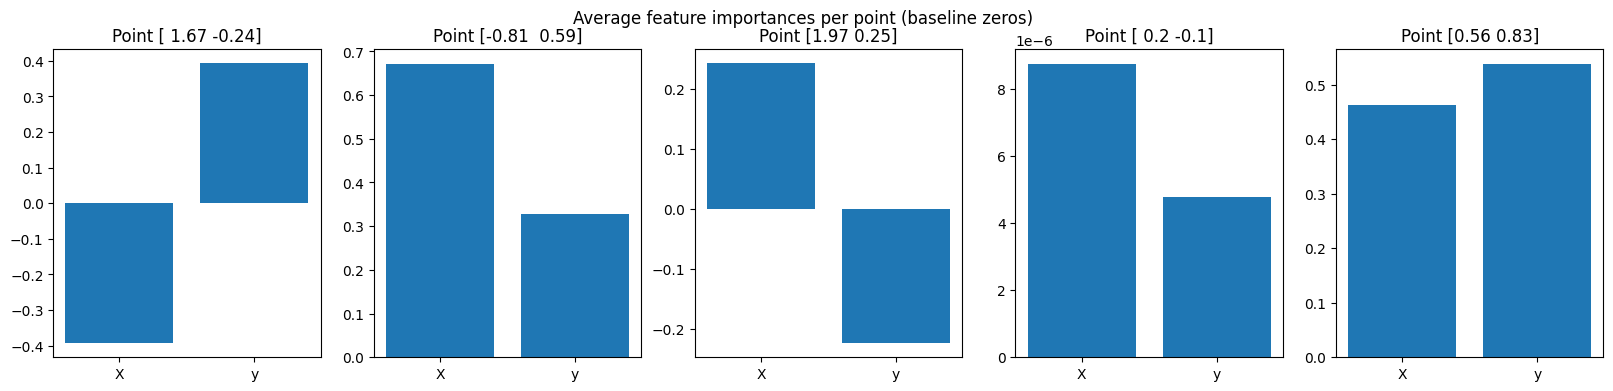

In [225]:
fig, axes = plt.subplots(1, len(points_to_explain_t), figsize=(4*len(points_to_explain_t),4))

for i,p in enumerate(points_to_explain_t):
    attr, _ = explain_ig(net, ig, p.reshape(1,-1),
                         target=int(net(torch.tensor(p.reshape(1,-1),dtype=torch.float32)).argmax()))
    axes[i].bar([0,1], attr[0])
    axes[i].set_xticks([0,1])
    axes[i].set_xticklabels(['X','y'])
    axes[i].set_title(f'Point {p.detach().numpy().round(2)}')
    
plt.suptitle('Average feature importances per point (baseline zeros)')
plt.show()

# Interpretation 

In integrated gradients, a positive attribution means the feature pushes the prediction toward the predicted class, while a negative attribution means it pushes away from it. The magnitude measures the strength of this influence.

For each point, the target was the predicted class, so: <br>For the point (1.67, −0.24), IG(x) = −0.39 and IG(y) = +0.39. The large attribution for y indicates that y=-0.24 strongly supports its classification into the sin class, and x=1.67 pushes it away from it.
For (−0.81, 0.59), IG(x) = 0.67 and IG(y) = 0.32, meaning both coordinates support the predicted class.
For (0.2, -0.1), both attributions are near-zero, which means both coordinates support both prediction classes almost equally. 

These interpretations are visible in the decision boundary plot, as, for instance, (0.2, -0.1) is positioned where both its x and y axis have points that belong to both classes equally. For (1.67, −0.24), we can see that most points along y=-0.24 belong to class 1. And for (−0.81, 0.59), in both axes, most points belong to class 0.

# Testing the completeness property

In [226]:
for p in points_to_explain_t:
    p = p.reshape(1,-1)
    baseline = torch.zeros_like(p)
    preds = net(torch.tensor(p, dtype=torch.float32)).detach().numpy()
    pred_class = preds.argmax()
    attributions, delta = ig.attribute(p, baselines=baseline,
                                       target=int(pred_class),
                                       return_convergence_delta=True)
    logits = net(p)
    logits_baseline = net(baseline)
    target = int(logits.argmax())
    diff = (logits[0,target] - logits_baseline[0,target]).item()
    sum_attr = attributions.sum().item()
    print('Point: ', p.detach().numpy().round(2))
    print('logit_diff: ', diff)
    print('sum_attr: ', sum_attr)
    print('delta: ', delta, "\n")

Point:  [[ 1.67 -0.24]]
logit_diff:  -5.602836608886719e-06
sum_attr:  -0.0004431605339050293
delta:  tensor([-0.0004]) 

Point:  [[-0.81  0.59]]
logit_diff:  0.9999619126319885
sum_attr:  0.9999620318412781
delta:  tensor([1.1921e-07]) 

Point:  [[1.97 0.25]]
logit_diff:  -0.00015980005264282227
sum_attr:  0.018198013305664062
delta:  tensor([0.0184]) 

Point:  [[ 0.2 -0.1]]
logit_diff:  1.3589859008789062e-05
sum_attr:  1.3497410691343248e-05
delta:  tensor([-9.2448e-08]) 

Point:  [[0.56 0.83]]
logit_diff:  0.9999839663505554
sum_attr:  1.0002849102020264
delta:  tensor([0.0003]) 



/tmp/ipykernel_465/1737481312.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  preds = net(torch.tensor(p, dtype=torch.float32)).detach().numpy()


# Interpretation

Completeness for integrated gradients means that the sum of all feature attributions for a point should equal the difference between the model’s output at that point and at the baseline. If the classifier’s output changes by a certain value when moving from baseline to input, the two IG components should sum to that value.

We can see that the sum of the attributions for each point is almost equal to the difference between the output of the model for the input vs. for the baseline, which verifies the completeness property.

# Zero vs. Mean Baseline

In [227]:
baseline_mean = X_train.mean(axis=0, keepdims=True)
print('Baseline mean:', baseline_mean)

for p in points_to_explain_t:
    attr_zero, _ = explain_ig(net, ig, p.reshape(1,-1), baseline=np.zeros((1,2)))
    attr_mean, _ = explain_ig(net, ig, p.reshape(1,-1), baseline=baseline_mean)
    print('Point', p.detach().numpy().round(2))
    print('  IG zeros:', attr_zero)
    print('  IG mean :', attr_mean)

Baseline mean: [[0.48758816 0.25507589]]
Point [ 1.67 -0.24]
  IG zeros: [[-0.3934689   0.39302573]]
  IG mean : [[-0.05848766  0.5393238 ]]
Point [-0.81  0.59]
  IG zeros: [[-0.6712314 -0.3287306]]
  IG mean : [[-0.25243074 -0.2666909 ]]
Point [1.97 0.25]
  IG zeros: [[ 0.24250554 -0.22430752]]
  IG mean : [[0.47695255 0.00372784]]
Point [ 0.2 -0.1]
  IG zeros: [[8.7318549e-06 4.7655562e-06]]
  IG mean : [[0.2549556  0.22589868]]
Point [0.56 0.83]
  IG zeros: [[-0.4624965  -0.53778833]]
  IG mean : [[-0.08047634 -0.4386666 ]]


# Interpretation 

We can see that for the mean baseline, the results are more interpretable as they lean more towards one of the features in most cases, and in the cases where the values were near zero for the zero baseline, we now have higher magnitudes. 

This is because the mean baseline lies closer to the actual data distribution, so the integrated gradient path passes through regions where the model’s gradients carry meaningful information about how each feature affects the output, while the zero baseline is far from most data points.

# Comparision to LIME and SHAP

In [228]:
# lime

explainer = lime_tabular.LimeTabularExplainer(
    X_train,
    feature_names=['X', 'y'],  
    class_names=['cos', 'sin'],     
    mode='classification'
)

for p in points_to_explain_t:
    p_np = p.detach().cpu().numpy() if torch.is_tensor(p) else p
    exp = explainer.explain_instance(p_np, lambda x: net(torch.tensor(x, dtype=torch.float32)).detach().numpy(), num_features=2)
    print('LIME exp for', p_np)
    print(exp.as_list(), '\n')


# shap

def predict_proba_for_shap(X_np):
    with torch.no_grad():
        t = torch.tensor(X_np, dtype=torch.float32)
        logits = net(t).detach().numpy()
        exps = np.exp(logits - logits.max(axis=1, keepdims=True))
        probs = exps / exps.sum(axis=1, keepdims=True)
        return probs

masker = shap.maskers.Independent(X_train)
kshap = shap.Explainer(predict_proba_for_shap, masker=masker, output_names=['0', '1'])
points_np = np.array([p.detach().cpu().numpy() if torch.is_tensor(p) else p for p in points_to_explain_t])

shap_vals = kshap(points_np)
print('SHAP values (KernelSHAP approx):')
print(shap_vals.values)

LIME exp for [ 1.6694424  -0.24286391]
[('y <= -0.20', 0.6283537249648276), ('X > 1.00', 0.11754571692404636)] 

LIME exp for [-0.80827624  0.58880347]
[('X <= -0.06', -0.2301622270257537), ('0.26 < y <= 0.70', -0.20576410517298888)] 

LIME exp for [1.9684578 0.2508223]
[('-0.20 < y <= 0.26', 0.21412358354689212), ('X > 1.00', 0.15207396271550264)] 

LIME exp for [ 0.20298819 -0.10396372]
[('-0.06 < X <= 0.48', 0.32938513996452895), ('-0.20 < y <= 0.26', 0.21736210945325388)] 

LIME exp for [0.5604681 0.828176 ]
[('y > 0.70', -0.5867771409421026), ('0.48 < X <= 1.00', -0.20703604464935368)] 

SHAP values (KernelSHAP approx):
[[[-0.04632187  0.04632187]
  [-0.17086888  0.17086888]]

 [[ 0.15048245 -0.15048245]
  [ 0.09442677 -0.09442677]]

 [[-0.163911    0.16391102]
  [-0.05321911  0.05321911]]

 [[-0.10641936  0.10641935]
  [-0.1107789   0.11077891]]

 [[ 0.01830548 -0.01830547]
  [ 0.22661244 -0.22661242]]]


# Interpretation <br>
Across all points, the signs and relative magnitudes are consistent